# Analysis of Enron emails

In [1]:
import pandas as pd
import json
import re
import numpy as np

from sklearn.externals import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import spacy

In [2]:
pd.set_option('display.max_columns', 50)

## Processing raw Enron email data

See notebook `01-download-enron-data.ipynb` for code to download the Enron email dataset.

In [3]:
path = '/Users/yuwenwu/insight/cultivate/'
with open(path + '/data/raw/enron.mbox.json', 'r') as json_data:
    emails_raw = json.load(json_data)

Remove emails without receivers.

In [4]:
emails = []
index = []
for idx, email in enumerate(emails_raw):
    if 'To' in email:
        emails.append(email)
        index.append(idx)

Some emails have the same sender and receiver. Let's remove those emails.

In [5]:
another_index = []
for idx, email in enumerate(emails):
    if email['From'] != email['To'][0]:
        another_index.append(idx)
        
emails = [emails[i] for i in another_index]

Remove emails not from `@enron.com`, as these are often spam, listserv or subscription emails.

In [6]:
enron_only = []
for idx, email in enumerate(emails):
    if email['From'].endswith('@enron.com'):
        enron_only.append(idx)
        
emails = [emails[i] for i in enron_only]

Remove forwarded emails, as these will give more noise than signal.

In [7]:
forwarded = []
for idx, email in enumerate(emails):
    subject = email['Subject']
    fwd_string = ['Fwd', 'Fw']
    if any(substring in subject for substring in fwd_string):
        continue
    else:
        forwarded.append(idx)

emails = [emails[i] for i in forwarded]

Remove any sender who sent only 1 or 2 emails or someone who only received one or two emails. Also remove emails from enron.announcements@enron.com, office.chairman@enron.com, arsystem@mailman.enron.com.

In [8]:
all_senders = []
for email in emails:
    all_senders.append(email['From'])

sender_df = pd.DataFrame({
    'sender':all_senders
})

sent_multiple_index = sender_df.groupby('sender').filter(lambda x: len(x) > 2 ).index
emails = [emails[i] for i in sent_multiple_index]

In [9]:
all_receivers = []
for email in emails:
    receiver = email['To']
    if len(receiver) > 1:
        all_receivers.append('group')
    else:
        all_receivers.append(receiver[0])

receiver_df = pd.DataFrame({
    'receiver':all_receivers
})

received_multiple_index = receiver_df.groupby('receiver').filter(lambda x: len(x) > 2 ).index
emails = [emails[i] for i in received_multiple_index]

In [10]:
emails_to_remove = ['enron.announcements@enron.com', 
                    'office.chairman@enron.com', 
                    'arsystem@mailman.enron.com',
                    'admin.enron@enron.com',
                    'enron.mailsweeper.admin@enron.com', 
                    'system.administrator@enron.com',
                   'perfmgmt@enron.com']

emails_to_keep = []
for idx, email in enumerate(emails):
    from_ = email['From']
    if from_ not in emails_to_remove:
        emails_to_keep.append(idx)

emails = [emails[i] for i in emails_to_keep]

Some emails actually contain the entire thread (i.e., all replies to the original email), and the text in the thread will affect downstream text analysis. Although a more sophisticated approach would be to save each part of the thread, for simplicity we will only save the latest email message, which is the text before double new line characters. Also remove text after `'Forwarded'`, `'Original Message'`, and `'From: '.

In [12]:
main_body = []
for email in emails:
    main_body.append(email['parts'][0]['content'])

In [13]:
def remove_extra_text(string, main_body = main_body):
    for idx, msg in enumerate(main_body):
        string_index = msg.find(string)
        if string_index != -1:
            main_body[idx] = msg[:string_index]
        else:
            main_body[idx] = msg
    return main_body

In [14]:
main_body = remove_extra_text('Original Message')
main_body = remove_extra_text('Forwarded')
main_body = remove_extra_text('From:')
main_body = remove_extra_text('To:')
main_body = remove_extra_text('Subject:')

Finally, remove duplicate and empty emails.

In [15]:
email_content = []
unique_email_index = []
tuples = []
for idx, (email, content) in enumerate(zip(emails, main_body)):
    
    if content.isspace():
        continue
        
    if content == '':
        continue
        
    tuple_ = (email['From'], email['To'], content)
    if tuple_ not in tuples:
        unique_email_index.append(idx)
        email_content.append(content)
        tuples.append(tuple_)
    
    else:
        continue

emails = [emails[i] for i in unique_email_index]

Clean email content.

In [17]:
#clean strings
for i in range(len(email_content)):
    email_content[i] = email_content[i].replace('\n', ' ')
    email_content[i] = email_content[i].replace('\t', ' ')
    email_content[i] = re.sub('--+', '', email_content[i])
    email_content[i] = re.sub(' +', ' ', email_content[i])
    email_content[i] = re.sub('[0-9]+/[0-9]+/[0-9]+ ([0-9]+:[0-9]+)* [a-zA-Z]{2}', '', email_content[i])
    email_content[i] = re.sub('@([a-zA-Z])*', '', email_content[i])
    email_content[i] = re.sub('/[a-zA-Z]*/[a-zA-Z]*', '', email_content[i])
    email_content[i] = email_content[i].strip()

Remove any duplicates that may arise after cleaning.

In [18]:
unique_email_index = []
tuples = []
for idx, (email, content) in enumerate(zip(emails, email_content)):

        
    tuple_ = (email['From'], email['To'], content)
    if tuple_ not in tuples:
        unique_email_index.append(idx)
        tuples.append(tuple_)
    
    else:
        continue

emails = [emails[i] for i in unique_email_index]
email_content = [email_content[i] for i in unique_email_index]

Use SpaCy to get POS tagging.

In [20]:
nlp = spacy.load('en')

In [21]:
caps = []
total_msg_lens = []
periods, commas = [], []
ex_marks, q_marks = [], []
word_tokens = []
pos = []
for email in email_content:
    caps.append(sum(1 for s in email if s.isupper()))
    total_msg_lens.append(len(email))
    periods.append(sum(1 for s in email if s == '.'))
    commas.append(sum(1 for s in email if s == ','))
    ex_marks.append(sum(1 for s in email if s == '!'))
    q_marks.append(sum(1 for s in email if s == '?'))
    #email = email.lower()
    pos.append(nlp(email))
    word_tokens.append(word_tokenize(email))

In [22]:
joblib.dump(email_content, path + '/data/processed/email_content.pkl');

In [23]:
punct = string.punctuation
word_counts = []
for i in range(len(word_tokens)):
    words = [w for w in word_tokens[i] if not w in punct]
    word_counts.append(len(words))

In [24]:
text_features = pd.DataFrame(
    {
        'caps':caps,
        'msg_len':total_msg_lens,
        'periods':periods,
        'commas':commas,
        'ex_marks':ex_marks,
        'q_marks':q_marks,
        'word_count':word_counts
    }
)

Add POS information.

In [25]:
from collections import defaultdict

pos_counts = []
for doc in pos:
    d = defaultdict(int)
    for word in doc:
        d[word.pos_] +=1
    pos_counts.append(d)

In [26]:
df_pos_counts = pd.DataFrame(pos_counts)
df_pos_counts.columns = df_pos_counts.columns.str.lower()
df_pos_counts.replace(np.nan, 0, inplace = True)
df_pos_counts.head()

,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0
2,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0


In [27]:
text_features = pd.concat([text_features, df_pos_counts], axis = 1)

Get number of sentences and average length of sentence in message.

In [28]:
num_sentences = []
sentence_len_mean = []
for email in emails:
    tokens = sent_tokenize(email['parts'][0]['content'])
    num_sentences.append(len(tokens))
    len_sentence = []
    for token in tokens:
        s = ''.join(ch for ch in token if ch not in string.punctuation)
        s = s.strip()
        len_sentence.append(len(s.split(' ')))
    if len_sentence:
        sentence_len_mean.append(np.mean(len_sentence))
    else:
        sentence_len_mean.append(0)

text_features['num_sentences'] = num_sentences
text_features['len_sentence_mean'] = sentence_len_mean

Get out how many recipients the email has.

In [29]:
num_recipients = []
for email in emails:
    num_recipients.append(len(email['To']))
    
text_features['num_recipients'] = num_recipients

Gender of senders and recipients (if multiple recipients, put 'Group' as gender because any gender effects will likely be washed out).

In [30]:
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive = False)

send_gender = []
receive_gender = []
for email in emails:
    
    send_name = email['X-From']
    #name structure is 'First, Last'
    send_name = send_name.split(' ', 1)[0]
    send_gender.append(d.get_gender(send_name))
    
    if len(email['To']) > 1:
        receive_gender.append('group')
    
    else:
        r_name = email['X-To']
        r_name = r_name.split(' ', 1)[0]
        gender = d.get_gender(r_name)
        receive_gender.append(gender)

In [31]:
text_features['send_gender'] = send_gender
text_features['receive_gender'] = receive_gender

Get sentiment scores

In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [33]:
analyzer = SentimentIntensityAnalyzer()

sentiments_list = []
for email in email_content:
    sentences = sent_tokenize(email)
    
    sentence_sentiments = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        sentence_sentiments.append(vs)
    
    msg_sentiments = {}
    for k in vs.keys():
        if sentence_sentiments:
            mean = sum(d[k] for d in sentence_sentiments) / len(sentence_sentiments)
            msg_sentiments[k] = mean
        else:
            msg_sentiments[k] = np.nan
    
    sentiments_list.append(msg_sentiments)

sentiments = pd.DataFrame(sentiments_list)

In [34]:
text_features = pd.concat([text_features, sentiments], axis = 1)

Identify pairs (not looking for pairs over time).

In [35]:
from datetime import datetime as dt

senders, receivers = [], []
dates = []
for email in emails:
    senders.append(email['From'])
    receive = email['To']
    if len(receive) > 1:
        receivers.append('group')
    else:
        receivers.append(receive[0])
    date = email['Date']
    date = dt.strptime(date, '%Y-%m-%d %H:%M:%S')
    dates.append(date)

In [36]:
text_features['sender'] = senders
text_features['receiver'] = receivers
text_features['date'] = dates

In [37]:
text_features.head()

,caps,commas,ex_marks,msg_len,periods,q_marks,word_count,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x,num_sentences,len_sentence_mean,num_recipients,send_gender,receive_gender,compound,neg,neu,pos,sender,receiver,date
0,1,0,0,20,0,0,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,4.0,1,male,male,0.0000,0.000,1.0000,0.0000,phillip.allen@enron.com,tim.belden@enron.com,2001-05-14 23:39:00
1,12,1,0,773,10,0,140,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0,10,13.9,1,male,male,0.2177,0.000,0.8987,0.1013,phillip.allen@enron.com,john.lavorato@enron.com,2001-05-04 20:51:00
2,6,1,0,180,2,0,34,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,3,11.0,1,male,male,0.0000,0.000,1.0000,0.0000,phillip.allen@enron.com,randall.gay@enron.com,2000-10-23 13:13:00
3,2,0,0,33,1,0,7,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1,6.0,1,male,male,-0.3400,0.324,0.6760,0.0000,phillip.allen@enron.com,greg.piper@enron.com,2000-08-31 12:07:00
4,5,1,0,56,0,1,9,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,2,4.5,1,male,male,0.0000,0.000,1.0000,0.0000,phillip.allen@enron.com,greg.piper@enron.com,2000-08-31 11:17:00


In [38]:
text_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 35 columns):
caps                 6080 non-null int64
commas               6080 non-null int64
ex_marks             6080 non-null int64
msg_len              6080 non-null int64
periods              6080 non-null int64
q_marks              6080 non-null int64
word_count           6080 non-null int64
adj                  6080 non-null float64
adp                  6080 non-null float64
adv                  6080 non-null float64
cconj                6080 non-null float64
det                  6080 non-null float64
intj                 6080 non-null float64
noun                 6080 non-null float64
num                  6080 non-null float64
part                 6080 non-null float64
pron                 6080 non-null float64
propn                6080 non-null float64
punct                6080 non-null float64
space                6080 non-null float64
sym                  6080 non-null float64
verb

### Visualizing sentiments

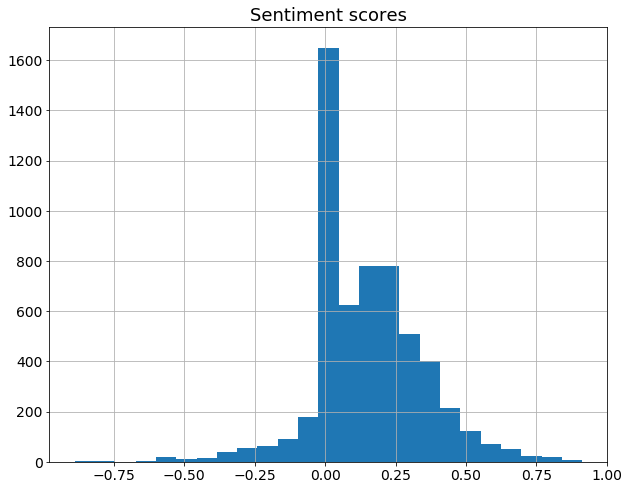

In [1347]:
#fig = plt.figure(1);

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

bins = 25

#fig = plt.subplot(221);
_ = text_features['compound'].hist(bins = bins);
_ = plt.title('Sentiment scores', fontsize = 18)
plt.tick_params(labelsize = 14);

# fig = plt.subplot(222);
# _ = text_features['neg'].hist(bins = bins);
# _ = plt.title('Negative sentiment score')


# fig = plt.subplot(223);
# _ = text_features['pos'].hist(bins = bins);
# _ = plt.title('Positive sentiment score')

# fig = plt.subplot(224);
# _ = text_features['neu'].hist(bins = bins);
# _ = plt.title('Neutral sentiment score')

# _ = plt.subplots_adjust(top=0.76)
# _ = plt.suptitle('Sentiment scores')
# _ = plt.tight_layout()

save_image = path + '/images/'
plt.savefig(save_image + 'sentiments.png');

In [960]:
num_emails_sent = pd.DataFrame(text_features['sender'].value_counts()).reset_index()
num_emails_sent.columns = ['sender', 'num_emails']

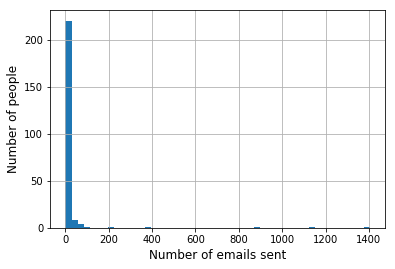

In [968]:
_ = num_emails_sent['num_emails'].hist(bins = 50)
_ = plt.ylabel('Number of people', fontsize = 12);
_ = plt.xlabel('Number of emails sent', fontsize = 12)
#plt.savefig(save_image + 'distri-emails-sent.png')

## Sentiments over time

In [71]:
from matplotlib.dates import date2num

In [1306]:
over_time = text_features.set_index(pd.DatetimeIndex(text_features['date']))
per_month = over_time.resample('M')
mean_sentiment = per_month['compound'].mean()
std = per_month['compound'].std()
x_axis_dates = date2num(text_features['date'].tolist())

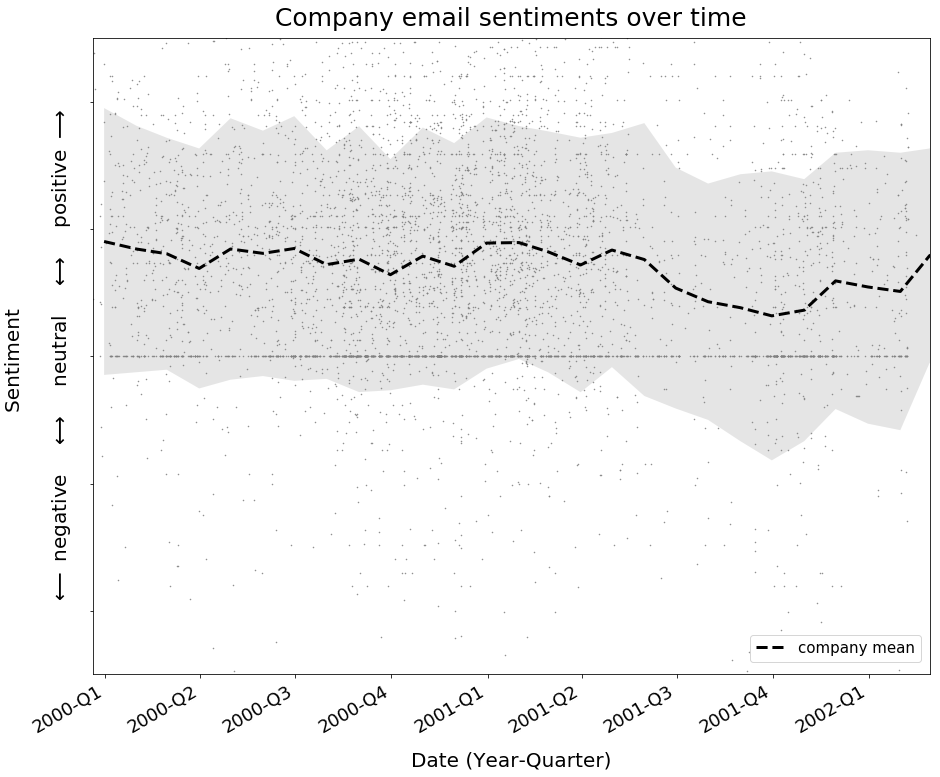

In [1334]:
y_label = ('Sentiment \n\n' + r'$\longleftarrow$' + 
           ' negative    ' + r'$\longleftrightarrow$' + '    neutral    ' +
           r'$\longleftrightarrow$' + '    positive ' + 
           r'$\longrightarrow$')

col = 'compound'
fig, ax = plt.subplots();
fig.set_size_inches(15, 13)

#plot individual points over time
ax.plot_date(x_axis_dates, np.asarray(text_features[col]), 
             markersize = 1, c = 'gray', marker = '.');

#plot mean sentiment
plt.plot(mean_sentiment, 'k--', label = 'company mean', linewidth = 3);

#plot std of mean sentiment
x_fill = date2num(mean_sentiment.index.tolist())
plt.fill_between(x_fill, mean_sentiment - std, mean_sentiment + std,
                alpha = 0.2, facecolor = 'gray');

#dimensions of plot
plt.gcf().autofmt_xdate();
ax.set_xlim([dt(1999, 12, 20), dt(2002, 2, 28)]);
ax.set_ylim(-0.5, 0.5);

#axis labels
plt.title('Company email sentiments over time', fontsize = 25, y = 1.01);
plt.xlabel('Date (Year-Quarter)', fontsize = 20, labelpad = 15);
plt.ylabel(y_label, fontsize = 20, labelpad = 20);

#axis ticks
plt.tick_params(axis = 'both', which = 'major', 
                labelsize = 18, labelleft = 'off');

x_pos = ax.get_xticks()
x_labels = np.array(['2000-Q1', '2000-Q2', '2000-Q3', '2000-Q4', 
                    '2001-Q1', '2001-Q2', '2001-Q3', '2001-Q4', 
                    '2002-Q1'])
plt.xticks(x_pos, x_labels)

#legend
lgd = plt.legend(bbox_to_anchor = (0.99, 0.02), 
                 loc = 'lower right', 
                 borderaxespad = 0.,
                 fontsize = 15,
                 markerscale = 2);

ax.figure.savefig(save_image + 'sentiments-over-time.png', 
                  bbox_extra_artists = (lgd,), bbox_inches = 'tight');

Code below for `views.py` file for webapp.

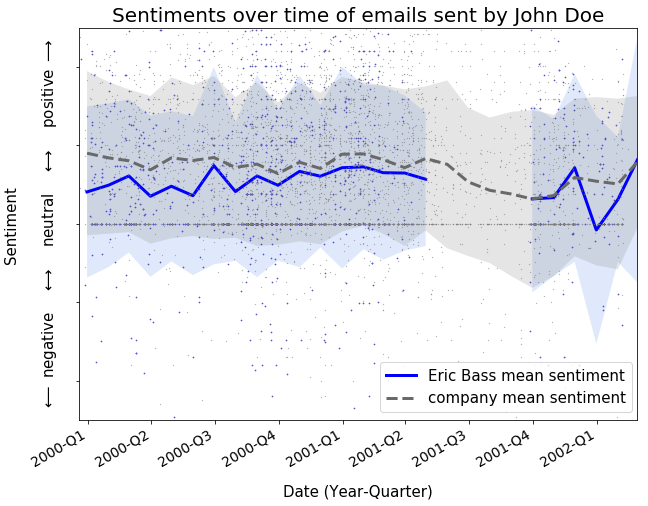

In [1365]:
email = 'eric.bass@enron.com'
name = 'Eric Bass'

fig, ax = plt.subplots();
fig.set_size_inches(10, 8)

#create necessary dfs, etc. for plotting of indiv info
indiv = text_features[text_features['sender'] == email]
indiv_dates = date2num(indiv['date'].tolist())
indiv_per_month = over_time[over_time['sender'] == email].resample('M')
indiv_mean = indiv_per_month['compound'].mean()
indiv_std = indiv_per_month['compound'].std()
x_indiv_fill = date2num(indiv_mean.index.tolist())

#color individual emails on plot
ax.plot_date(indiv_dates, np.array(indiv[col]), 
             markersize = 1, c = 'blue', marker = '.')

#plot individual mean
plt.plot(indiv_mean, 'b', label = name + ' mean sentiment', linewidth = 3);
plt.fill_between(x_indiv_fill, indiv_mean - indiv_std, indiv_mean + indiv_std,
                alpha = 0.2, facecolor = 'cornflowerblue');

#plot all points
x_axis_dates = date2num(text_features['date'].tolist())
ax.plot_date(x_axis_dates, np.array(text_features[col]), 
             markersize = 0.5, c = 'gray', marker = '.');

#plot company mean and std
plt.plot(mean_sentiment, '--', c = 'dimgray', 
         label = 'company mean sentiment', linewidth = 3);
plt.fill_between(x_fill, mean_sentiment - std, mean_sentiment + std,
                alpha = 0.2, facecolor = 'gray');

plt.gcf().autofmt_xdate();
ax.set_xlim([dt(1999, 12, 20), dt(2002, 2, 28)]);
ax.set_ylim(-0.5, 0.5);

plt.title('Sentiments over time of emails sent by John Doe', fontsize = 20);
plt.xlabel('Date (Year-Quarter)', fontsize = 15, labelpad = 15);
plt.ylabel(y_label, fontsize = 15, labelpad = 20);

#axis ticks
plt.tick_params(axis = 'both', which = 'major', 
                labelsize = 14, labelleft = 'off');

x_pos = ax.get_xticks()
x_labels = np.array(['2000-Q1', '2000-Q2', '2000-Q3', '2000-Q4', 
                    '2001-Q1', '2001-Q2', '2001-Q3', '2001-Q4', 
                    '2002-Q1'])
plt.xticks(x_pos, x_labels)

lgd = plt.legend(bbox_to_anchor = (0.99, 0.02), 
                 loc = 'lower right', 
                 borderaxespad = 0.,
                 fontsize = 15,
                 markerscale = 2);

ax.figure.savefig(save_image + 'indiv-sentiments.png', 
                  bbox_extra_artists = (lgd,), bbox_inches = 'tight');

## Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [40]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

Drop categorical columns, as clustering can't handle those features.

In [41]:
to_drop = ['send_gender', 'receive_gender', 'sender', 'receiver', 'date']
for_clustering = text_features.drop(to_drop, axis = 1)
X_matrix = for_clustering.as_matrix()

In [42]:
imp = Imputer(missing_values = 'NaN', strategy = 'mean')
X_imp = imp.fit_transform(X_matrix)

scaler = StandardScaler()
X = scaler.fit_transform(X_imp)

In [48]:
eps_list = [0.01, 0.05, 0.1, 0.5, 1]
min_samples_list = [10, 15]

best_score = -2
best_params = {
    'eps':None,
    'min_samples':None
}
for eps in eps_list:
    for min_samples in min_samples_list:
        db = DBSCAN(metric = 'cosine', min_samples = min_samples, eps = eps)
        _ = db.fit(X);
        db_clusters = list(db.labels_)
        if len(set(db_clusters)) == 1:
            continue
        else:
            score = silhouette_score(X, db_clusters, metric = 'cosine')
            if score > best_score:
                best_score = score
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

best_score
best_params

0.099265971619897822

{'eps': 0.1, 'min_samples': 20}

In [52]:
db = DBSCAN(metric = 'cosine',
           min_samples = 20,
           eps = 0.1)
db.fit(X)
db_clusters = pd.Series(db.labels_)
db_clusters.value_counts()

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=20, n_jobs=1, p=None)

 0    3234
-1    2262
 1     373
 2     111
 3      78
 4      22
dtype: int64

In [56]:
joblib.dump(db, path + '/models/dbscan.pkl');

In [53]:
def print_email(index):
    print('Message: ' + str(index))
    print('From: ' + emails[index]['From'])
    print('To: ')
    print(emails[index]['To'])
    print(emails[index]['parts'][0]['content'])

In [54]:
def get_emails_in_cluster(index, labels = db_clusters, emails = email_content):
    c_index = labels[labels == index].index
    cluster = [emails[i] for i in c_index]
    return cluster

In [634]:
import random

i = -1
c = get_emails_in_cluster(i)
print('\n')
print('{} messages in cluster {}.'.format(len(c), i))
#randomly sample 22 from list
[c[i] for i in sorted(random.sample(range(len(c)), 22))]



2262 messages in cluster -1.


['Are there behind closed doors discussions being held prior to the meeting? Is there the potential for a surprise announcement of some sort of fixed price gas or power cap once the open meeting finally happens?',
 'Reagan, I am still reviewing the numbers but here are some initial thoughts. Are you proposing a cost plus contract with no cap? What role would you play in obtaining financing? Any experience with FHA 221(d) loans? Although your fees are lower than George and Larry I am still getting market quotes lower yet. I have received estimates structured as follows: 5% - onsite expenses, supervision, clean up, equipment 2%- overhead 4%- profit I just wanted to give you this initial feedback. I have also attached an extremely primitive spreadsheet to outline the project. As you can see even reducing the builders fees to the numbers above the project would only generate $219,194 of cash flow for a return of 21%. I am not thrilled about such a low return. I think I need to find a way t

In [635]:
cluster_labels = {
    -1:'Updates and miscellaneous commentary',
    0:'Direct and to the point',
    1:'Business discussions',
    2:'Casual and personal',
    3:'Company announcements',
    4:'Meetings and interviews'
}

#### Visualization of clusters with t-SNE

In [58]:
from sklearn.manifold import TSNE
import generate_random_color as gen

In [59]:
learning_rates = [100, 250, 500, 750, 1000]
fitted_tsnes = []

for rate in learning_rates:
    tsne = TSNE(learning_rate = rate)
    fitted_tsnes.append(tsne.fit_transform(X))

In [107]:
joblib.dump(fitted_tsnes, path + '/models/fitted_tsnes.pkl');

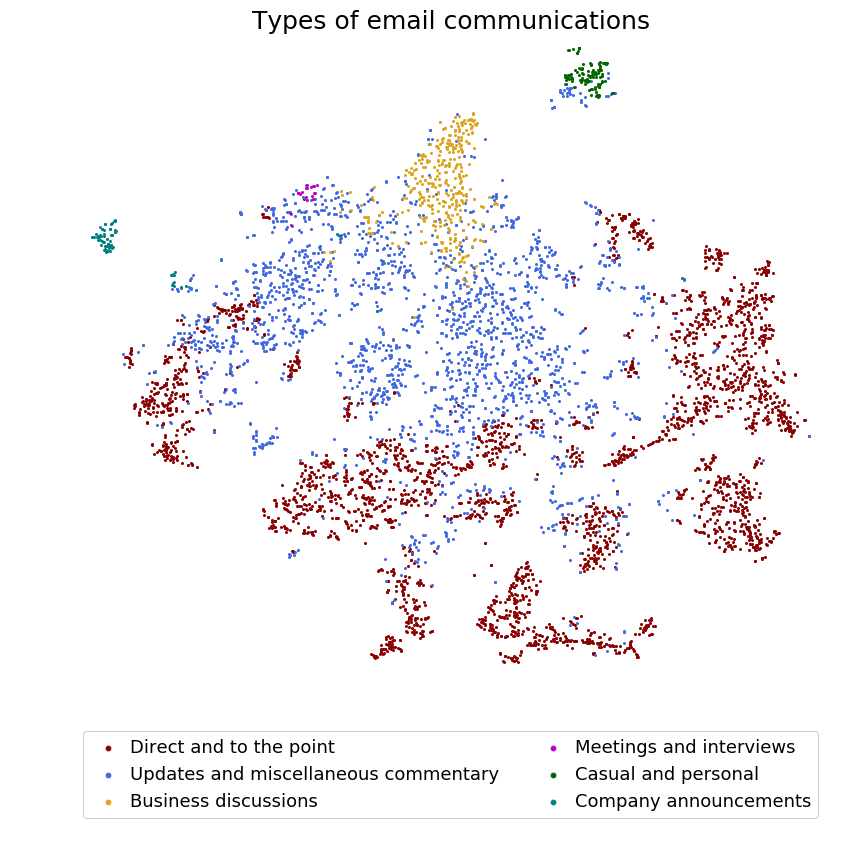

In [1340]:
#for i in range(len(fitted_tsnes)):
#use learning_rate = 750

colors = [
    'darkred',
    'royalblue',
    'goldenrod',
    'm',
    'darkgreen',
    'teal'
]

tsne_df = pd.DataFrame(fitted_tsnes[-2], columns = ['dimension 1', 'dimension 2'])

#tsne_df['cluster'] = db_clusters
tsne_df['cluster_labels'] = db_clusters
tsne_df['cluster_labels'].replace(cluster_labels, inplace = True)

ax = sns.lmplot('dimension 1', 'dimension 2', tsne_df,
                hue = 'cluster_labels', legend = False,
                fit_reg = False, palette = colors, 
                size = 12, scatter_kws = {'alpha':1, 's':4})

plt.title('Types of email communications', 
          fontsize = 25, y = 0.97);

lgd = plt.legend(loc = 'lower center',
                ncol = 2,
                borderaxespad = 0.,
                fontsize = 18,
                markerscale = 2.4,
                handletextpad = 0.2)

lgd.get_frame().set_alpha(1);

plt.axis('off');
plt.tight_layout();

plt.savefig(save_image + 'tsne.png', 
            bbox_extra_artists = (lgd,), bbox_inches = 'tight');

Plot individual's emails by cluster.

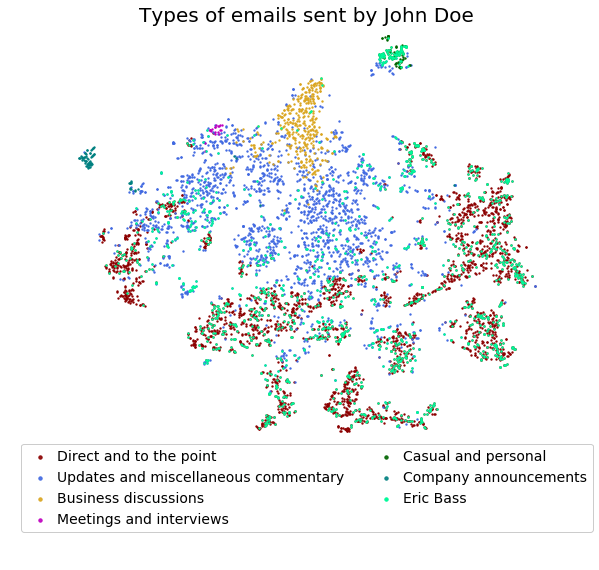

In [1364]:
#for i in range(len(fitted_tsnes)):
#use learning_rate = 750
tsne_df = pd.DataFrame(fitted_tsnes[-2], columns = ['dimension 1', 'dimension 2'])

#tsne_df['cluster'] = db_clusters
tsne_df['cluster_labels'] = db_clusters
tsne_df['cluster_labels'].replace(cluster_labels, inplace = True)

g = sns.lmplot('dimension 1', 'dimension 2', tsne_df,
                hue = 'cluster_labels', legend = False,
                fit_reg = False, palette = colors, 
                size = 8, scatter_kws = {'alpha':0.9, 's':2})

#plot individual's emails
indiv_pts = text_features[text_features['sender'] == email].index
indiv_pts = tsne_df.iloc[indiv_pts]
plt.scatter(indiv_pts['dimension 1'], indiv_pts['dimension 2'], 
            c = 'mediumspringgreen', s = 2, label = name);

plt.title('Types of emails sent by John Doe', 
          fontsize = 20, y = 0.97);

plt.axis('off');

lgd = plt.legend(loc = 'lower center',
                ncol = 2,
                borderaxespad = 0.,
                fontsize = 14,
                markerscale = 2.4,
                handletextpad = 0.2)

lgd.get_frame().set_alpha(1);

plt.savefig(save_image + 'tsne-indiv.png', 
            bbox_extra_artists = (lgd,), bbox_inches = 'tight');

### Analyzing emails per cluster

In [821]:
text_features['cluster'] = db_clusters
text_features['cluster_labels'] = db_clusters
text_features['cluster_labels'].replace(cluster_labels, inplace = True)
groupby_cluster = text_features.groupby('cluster_labels')

In [863]:
joblib.dump(text_features, path + '/data/processed/text_features.pkl');

In [294]:
def get_crosstab(col1, col2 = 'cluster_labels', df = text_features):
    return pd.crosstab(df[col2], df[col1]).apply(lambda r: r/r.sum(), axis = 1)

In [295]:
def combine_gender_cols(df, genders = ['male', 'female']):
    for gender in genders:
        df[gender] = df[gender] + df['mostly_' + gender]
        df.drop('mostly_' + gender, axis = 1, inplace = True)
    return df

In [296]:
def add_prefix_col_name(prefix, df):
    df.columns = [prefix + str(col) for col in df.columns]
    return df

In [297]:
def create_summary_df(df, prefix):
    df = combine_gender_cols(df = df)
    df = add_prefix_col_name(prefix = prefix, df = df)
    return df

In [822]:
receive_crosstab = get_crosstab('receive_gender')
receive_crosstab = create_summary_df(receive_crosstab, 'r_gen_')
receive_crosstab.drop('r_gen_andy', axis = 1, inplace = True)

In [823]:
send_crosstab = get_crosstab('send_gender')
send_crosstab = create_summary_df(send_crosstab, 's_gen_')

In [824]:
receive_all = pd.DataFrame(text_features['receive_gender'].value_counts(normalize = True)).T
receive_all = create_summary_df(receive_all, 'r_gen_')
receive_all.drop('r_gen_andy', axis = 1, inplace = True)
receive_all.index = ['All company emails']

In [825]:
send_all = pd.DataFrame(text_features['send_gender'].value_counts(normalize = True)).T
send_all = create_summary_df(send_all, 's_gen_')
send_all.index = ['All company emails']

Enron vs. non-Enron emails

In [826]:
def from_enron(col, df = text_features):
    enron = []
    for email_address in df[col].tolist():
        if email_address.endswith('@enron.com'):
            enron.append(True)
        elif email_address == 'group':
            enron.append(True)
        else:
            enron.append(False)
    df[col + '_enron'] = enron
    return df

In [827]:
#all sender emails are from enron
#text_features = from_enron('sender')
text_features = from_enron('receiver')

In [828]:
r_enron = pd.DataFrame(text_features['receiver_enron'].value_counts(normalize = True)).T
r_enron.columns = ['receive_enron_F', 'receive_enron_T']
r_enron.index = ['All company emails']

In [829]:
enron_crosstab = get_crosstab('receiver_enron')
enron_crosstab.columns = ['receive_enron_F', 'receive_enron_T']

In [830]:
cluster_summary = pd.DataFrame({
    'compound_mean':groupby_cluster['compound'].mean(),
    'n_samples':text_features['cluster_labels'].value_counts()
})

cluster_summary = pd.concat([cluster_summary, receive_crosstab, send_crosstab, enron_crosstab], axis = 1)

In [831]:
all_summary = pd.DataFrame({
    'compound_mean':text_features['compound'].mean(),
    'n_samples':len(text_features)
}, index = ['All company emails'])

all_summary = pd.concat([all_summary, receive_all, send_all, r_enron], axis = 1)

In [832]:
#pd.options.display.float_format = '{:.3f}'.format
summary = cluster_summary.append(all_summary)
summary

,compound_mean,n_samples,r_gen_female,r_gen_group,r_gen_male,r_gen_unknown,receive_enron_F,receive_enron_T,s_gen_female,s_gen_male,s_gen_unknown
Business discussions,0.178,373,0.209,0.402,0.196,0.193,0.121,0.879,0.560,0.319,0.121
Casual and personal,0.263,111,0.171,0.045,0.117,0.667,0.676,0.324,0.207,0.775,0.018
Company announcements,0.327,78,0.000,1.000,0.000,0.000,0.000,1.000,0.782,0.077,0.141
Direct and to the point,0.117,3234,0.236,0.201,0.236,0.326,0.176,0.824,0.180,0.568,0.252
Meetings and interviews,0.210,22,0.045,0.864,0.000,0.091,0.045,0.955,0.227,0.591,0.182
Updates and miscellaneous commentary,0.165,2262,0.234,0.328,0.161,0.276,0.194,0.806,0.373,0.441,0.186
All company emails,0.146,6080,0.229,0.270,0.200,0.300,0.814,0.186,0.283,0.503,0.213


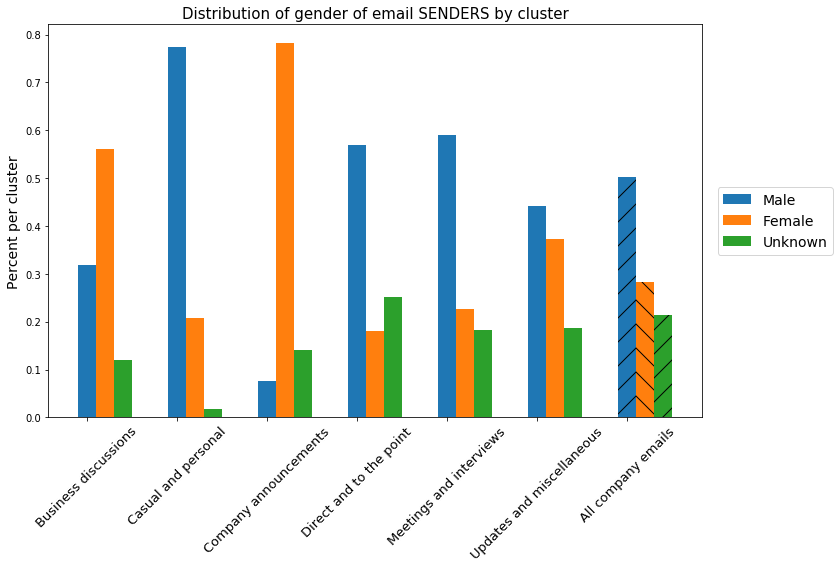

In [953]:
ind = np.arange(len(summary))
width = 0.2
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

rects1 = ax.bar(ind, summary['s_gen_male'], width)
rects2 = ax.bar(ind + width, summary['s_gen_female'], width)
rects3 = ax.bar(ind + 2 * width, summary['s_gen_unknown'], width)

ax.set_ylabel('Percent per cluster', fontsize = 14);
ax.set_title('Distribution of gender of email SENDERS by cluster', fontsize = 15);

ax.set_xticks(ind);
ax.set_xticklabels(('Business discussions', 
                    'Casual and personal', 
                    'Company announcements', 
                    'Direct and to the point', 
                    'Meetings and interviews', 
                   'Updates and miscellaneous',
                   'All company emails'), 
                   rotation = 45, 
                   fontsize = 13);

rects1[-1].set_hatch('/')
rects2[-1].set_hatch('\\')
rects3[-1].set_hatch('/')

lgd = plt.legend((rects1[0], rects2[0], rects3[0]), ('Male', 'Female', 'Unknown'), 
                 bbox_to_anchor=(1.2, 0.5), 
                 loc='center right', 
                 borderaxespad=0.,
                fontsize = 14,
                markerscale = 2);


plt.tight_layout();
plt.savefig(save_image + 'email-sender-clusters.png',
           bbox_extra_artists=(lgd,), bbox_inches='tight');

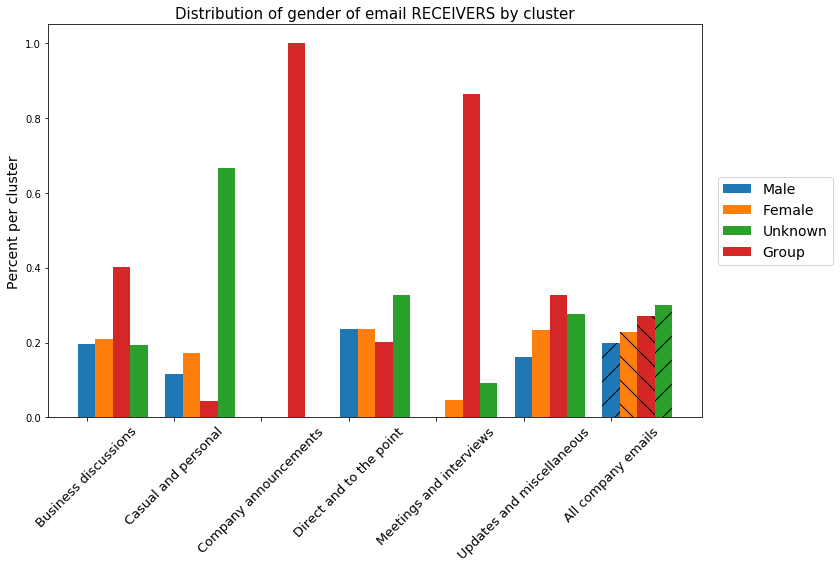

In [952]:
ind = np.arange(len(summary))
width = 0.2
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

rects1 = ax.bar(ind, summary['r_gen_male'], width)
rects2 = ax.bar(ind + width, summary['r_gen_female'], width)
rects3 = ax.bar(ind + 3*width, summary['r_gen_unknown'], width)
rects4 = ax.bar(ind + 2*width, summary['r_gen_group'], width)

ax.set_ylabel('Percent per cluster', fontsize = 14);
ax.set_title('Distribution of gender of email RECEIVERS by cluster', fontsize = 15);

ax.set_xticks(ind);
ax.set_xticklabels(('Business discussions', 
                    'Casual and personal', 
                    'Company announcements', 
                    'Direct and to the point', 
                    'Meetings and interviews', 
                   'Updates and miscellaneous',
                   'All company emails'), 
                   rotation = 45, 
                   fontsize = 13);

rects1[-1].set_hatch('/')
rects2[-1].set_hatch('\\')
rects3[-1].set_hatch('/')
rects4[-1].set_hatch('\\')

lgd = plt.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('Male', 'Female', 'Unknown', 'Group'), 
                 bbox_to_anchor=(1.2, 0.5), 
                 loc='center right', 
                 borderaxespad=0.,
                fontsize = 14,
                markerscale = 2);


plt.tight_layout();
plt.savefig(save_image + 'email-receiver-clusters.png',
           bbox_extra_artists=(lgd,), bbox_inches='tight');

In [1038]:
counts_per_cluster = text_features['cluster_labels'].value_counts()
counts_per_cluster = counts_per_cluster.sort_index()

Plot mean sentiment per cluster.

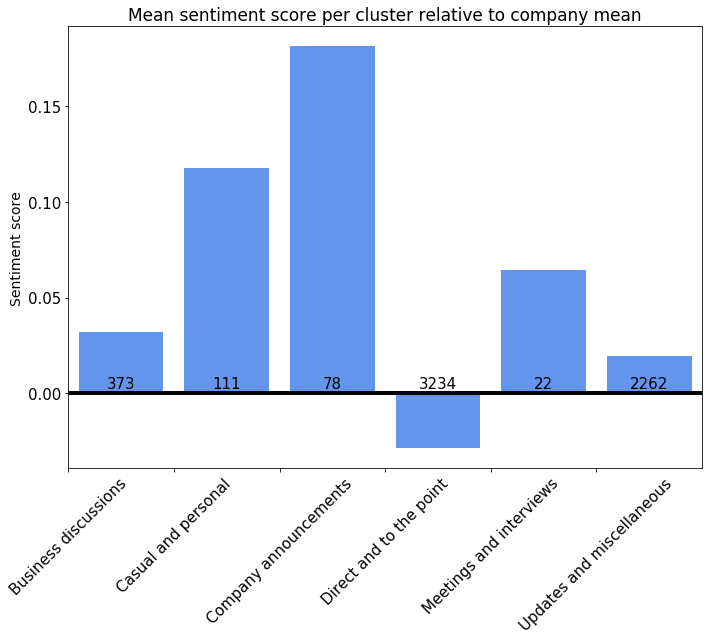

In [1049]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 9)

mean = summary['compound_mean'][-1]
summary2 = summary.copy()
summary2['relative_mean'] = summary2['compound_mean'] - mean
summary2.drop('All company emails', inplace = True)
ind2 = np.arange(len(summary2))

_ = ax.bar(ind2, summary2['relative_mean'], color = 'cornflowerblue');

ax.set_xticks(ind2 - 0.5);
ax.set_xticklabels(('Business discussions', 
                    'Casual and personal', 
                    'Company announcements', 
                    'Direct and to the point', 
                    'Meetings and interviews', 
                   'Updates and miscellaneous'), 
                   rotation = 45);


plt.hlines(0, -0.5, 6.5, label = 'mean sentiment', linewidth = 4);
plt.xlim(-0.5, 5.5);

rects = ax.patches

#gets mean of each cluster
#labels = []
#for mean in summary2['relative_mean']:
#    labels.append('{:.3}'.format(mean))

for index, (rect, count) in enumerate(zip(rects, counts_per_cluster)):
    ax.text(rect.get_x() + rect.get_width()/2, 0.001,
            count, ha='center', va='bottom', 
            fontsize = 15);
    
plt.title('Mean sentiment score per cluster relative to company mean', fontsize = 17);
plt.ylabel('Sentiment score', fontsize = 14);
#plt.xlabel('Cluster labels', fontsize = 14);
plt.tick_params(axis='both', which='major', labelsize=15);

#plt.legend(fontsize = 13);
plt.tight_layout();
ax.figure.savefig(save_image + 'sentiment-per-cluster.png');

Plot mean sentiments of each cluster over time.

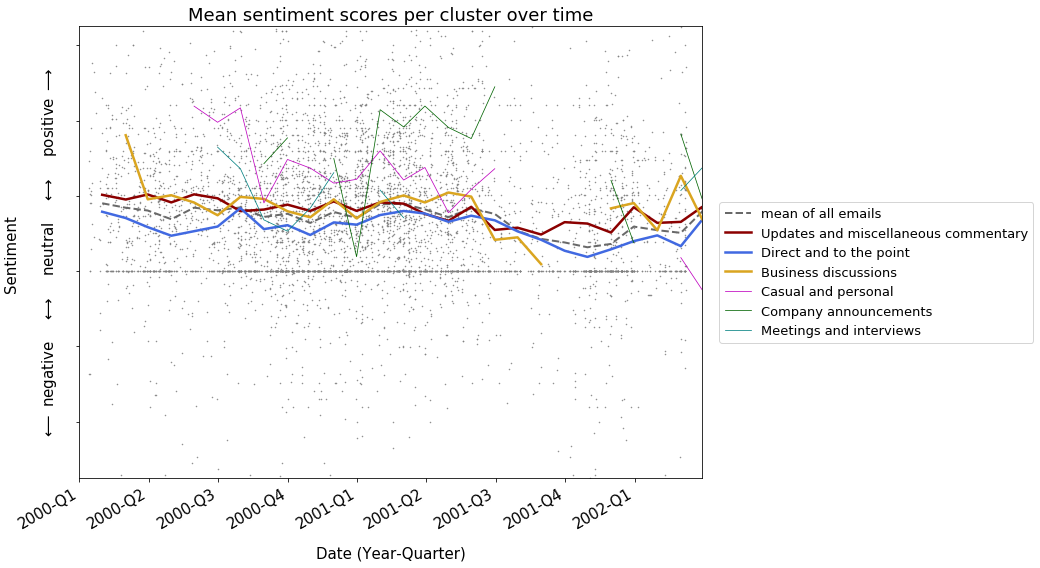

In [1363]:
fig, ax = plt.subplots();
fig.set_size_inches(10, 8)

ax.plot_date(x_axis_dates, np.array(text_features[col]), markersize = 0.5, c = 'gray');
plt.plot(mean_sentiment, '--', c = 'dimgray', linewidth = 2, label = 'mean of all emails')

for cluster, color in cluster_colors.items():
    pts_to_plot = text_features[text_features['cluster_labels'] == cluster]
    pts_dates = date2num(pts_to_plot['date'].tolist())
    cluster_mean = over_time[over_time['cluster_labels'] == cluster].resample('M')['compound'].mean()
    if cluster in ['Casual and personal', 'Company announcements', 'Meetings and interviews']:
        plt.plot(cluster_mean, c = color, label = cluster, linewidth = 0.75);
    else:
        plt.plot(cluster_mean, c = color, label = cluster, linewidth = 2.5);

lgd = plt.legend(bbox_to_anchor=(1.28, 0.3), 
                 loc='lower center', 
                 borderaxespad=0., 
                 fontsize = 13);

plt.gcf().autofmt_xdate();
ax.set_xlim([dt(1999, 12, 1), dt(2002, 2, 28)]);
ax.set_ylim(-0.55, 0.65)

plt.title('Mean sentiment scores per cluster over time', fontsize = 18)
plt.ylabel(y_label, fontsize = 15, labelpad = 20);
plt.xlabel('Date (Year-Quarter)', fontsize = 15, labelpad = 15);

#axis ticks
plt.tick_params(axis = 'both', which = 'major', 
                labelsize = 15, labelleft = 'off');

x_pos = ax.get_xticks()
x_labels = np.array(['2000-Q1', '2000-Q2', '2000-Q3', '2000-Q4', 
                    '2001-Q1', '2001-Q2', '2001-Q3', '2001-Q4', 
                    '2002-Q1'])
plt.xticks(x_pos, x_labels);

plt.tight_layout();
plt.savefig(save_image + 'cluster-sentiments-time.png', 
            bbox_extra_artists=(lgd,), bbox_inches='tight');

Plot individual's emails by cluster type and sentiment over time.

In [687]:
cluster_colors = {}
for value, color in zip(cluster_labels.values(), colors):
    cluster_colors[value] = color

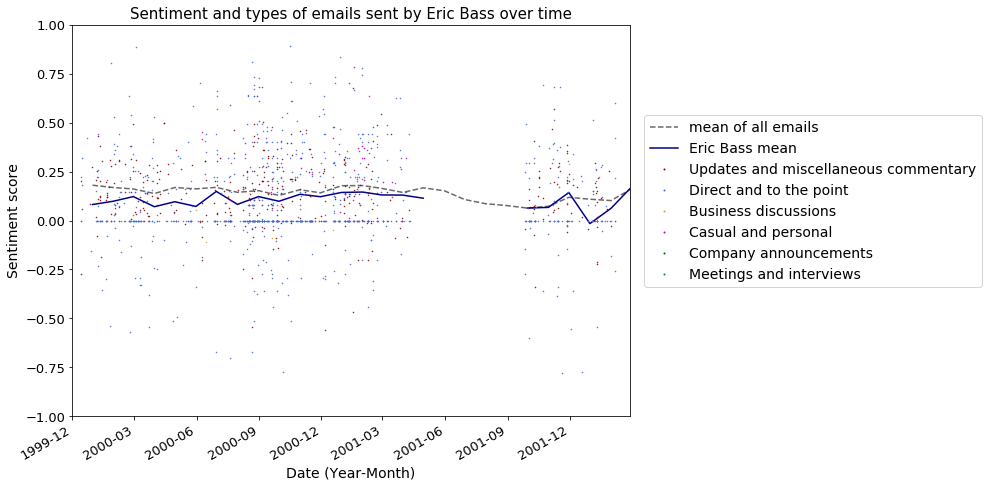

In [1098]:
x_axis_dates = date2num(text_features['date'].tolist())

col = 'compound'
fig, ax = plt.subplots();
fig.set_size_inches(10, 8)

plt.plot(mean_sentiment, '--', c = 'dimgray', label = 'mean of all emails');
indiv_mean = over_time[over_time['sender'] == email].resample('M')['compound'].mean()
plt.plot(indiv_mean, 'darkblue', label = name + ' mean')

#indiv = text_features[text_features['sender'] == name]

#color by cluster labels
for label, color in cluster_colors.items():
    pts_to_plot = indiv[indiv['cluster_labels'] == label]
    pts_dates = date2num(pts_to_plot['date'].tolist())
    ax.plot_date(pts_dates, pts_to_plot[col], markersize = 0.5, c = color, label = label);

plt.gcf().autofmt_xdate();
ax.set_xlim([dt(1999, 12, 1), dt(2002, 2, 28)]);
ax.set_ylim(-1, 1);

plt.title('Sentiment and types of emails sent by {} over time'.format(name), fontsize = 15);
plt.ylabel('Sentiment score', fontsize = 14)
plt.xlabel('Date (Year-Month)', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=13);

lgd = plt.legend(bbox_to_anchor=(1.63, 0.55), 
                 loc=5, 
                 borderaxespad=0.,
                fontsize = 14,
                markerscale = 2);

#plt.savefig('indiv-sentiment-clusters.png', bbox_extra_artists=(lgd,), bbox_inches='tight');

Plot mean sentiments by whether recipient was male or female.

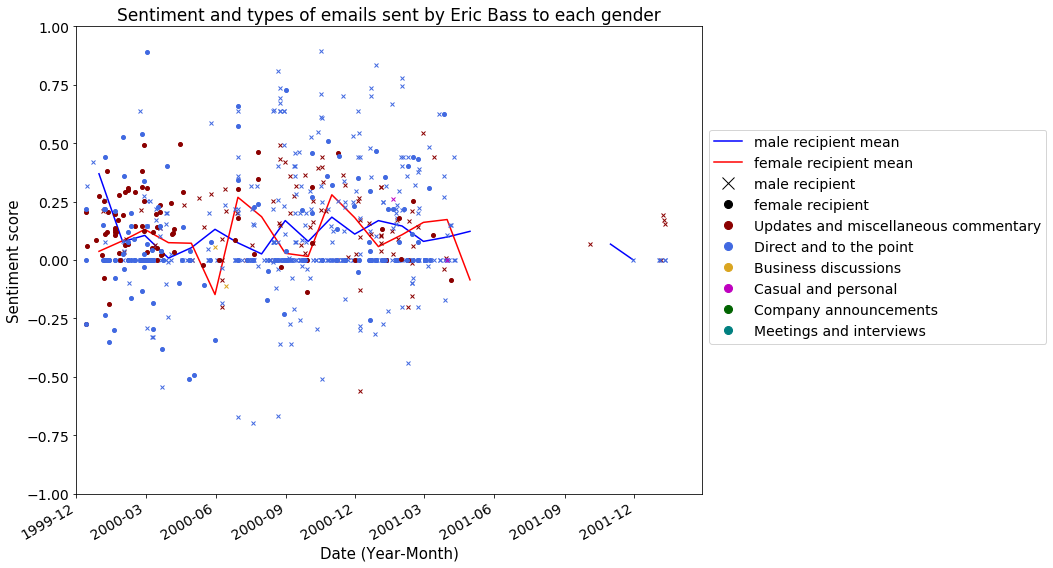

In [1088]:
fig, ax = plt.subplots();
fig.set_size_inches(10, 8)

male_mean = over_time[(over_time['sender'] == email) & (over_time['receive_gender'] == 'male')]\
.resample('M')['compound'].mean();
plt.plot(male_mean, 'blue', label = 'male recipient mean');

female_mean = over_time[(over_time['sender'] == email) & (over_time['receive_gender'] == 'female')]\
.resample('M')['compound'].mean();
plt.plot(female_mean, 'red', label = 'female recipient mean');

#plot fake points for legend markers
plt.plot_date(x_axis_dates[0], 10, marker = 'x', 
              label = 'male recipient', color = 'k');

plt.plot_date(x_axis_dates[0], 10, marker = 'o', 
              label = 'female recipient', color = 'k', 
              markersize = 4);

indiv = text_features[text_features['sender'] == email]
female = indiv[indiv['receive_gender'] == 'female']
male = indiv[indiv['receive_gender'] == 'male']

##color by cluster labels
for label, color in cluster_colors.items():
    pts_to_plot = male[male['cluster_labels'] == label]
    pts_dates = date2num(pts_to_plot['date'].tolist())
    ax.plot_date(pts_dates, np.array(pts_to_plot[col]), markersize = 4, 
                 c = color, marker = 'x');

for label, color in cluster_colors.items():
    pts_to_plot = female[female['cluster_labels'] == label]
    pts_dates = date2num(pts_to_plot['date'].tolist())
    ax.plot_date(pts_dates, pts_to_plot[col], markersize = 4, 
                 c = color, label = label, marker = 'o');

plt.gcf().autofmt_xdate();
ax.set_ylim(-1, 1);
ax.set_xlim([dt(1999, 12, 1), dt(2002, 2, 28)]);

plt.title('Sentiment and types of emails sent by {} to each gender'.format(name, gender), fontsize = 17);
plt.ylabel('Sentiment score', fontsize = 15)
plt.xlabel('Date (Year-Month)', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=14);

lgd = plt.legend(bbox_to_anchor=(1.55, 0.55), 
                 loc=5, 
                 borderaxespad=0.,
                fontsize = 14,
                markerscale = 2);

plt.tight_layout();
#plt.savefig('indiv-sentiment-clusters-gender.png', bbox_extra_artists=(lgd,), bbox_inches='tight');

## For webapp

For the webapp, let's only display the people who sent aroud 100 emails or more, otherwise there is not enough data for a meaningful plot.

In [1249]:
text_features['sender'].value_counts().head(6)

eric.bass@enron.com        1404
john.arnold@enron.com      1137
sally.beck@enron.com        877
phillip.allen@enron.com     382
k..allen@enron.com          215
shona.wilson@enron.com       93
Name: sender, dtype: int64

In [1253]:
for k, v in sender_name_to_email.items():
    if v == 'k..allen@enron.com':
        print(k)

Allen, Phillip K.


In [1220]:
for k, v in sender_name_to_email.items():
    if v == 'phillip.allen@enron.com':
        print(k)

Phillip K Allen


Phillip Allen has two email addresses. Let's replace one of the addresses for the webapp.

In [1226]:
features_webapp = text_features.copy()
features_webapp['sender'] = features_webapp['sender']\
.replace(['k..allen@enron.com'], 'phillip.allen@enron.com')
joblib.dump(features_webapp, '12-features_webapp.pkl');

In [1344]:
top_senders = features_webapp['sender'].value_counts().head().sum()
top_senders_percent = features_webapp['sender'].value_counts().head().sum() / len(features_webapp)
print('{0} or {1:.2%} of emails were sent by the top 5 email senders.'.format(top_senders, top_senders_percent))

4108 or 67.57% of emails were sent by the top 5 email senders.
